<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> Exercise 2: Regression with Stochastic Gradient Descent </h1>

<hr />
<center>Constructor Academy, 2024</center>

## Part 1: Gradient Descent

Implement your own (GD) function for fitting a linear regression model to yesterday’s salary data. Use matrix algebra! You are provided with a helper notebook which contains the relevant formulas und contains the basic structure.

   - Implement standard (vanilla) gradient descent.

   - Investigate the effect of different learning rates.

## Part 2: Stochastic Gradient Descent

- Create an additional function for stochastic gradient descent. Make sure that you shuffle the dataset befor each new run. Why? What happens if you don’t shuffle them?

- Implement a linear regression model with sklearn and compare it’s result with those from your GD functions.

## Bonus: Mini Batch

Generalize your GD function so that it works with batches of arbitrary size between 1 (stochastic GD) and n (vanilla GD). What are advantages of using mini batch GD?

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#%load_ext lab_black

In [2]:
from typing import Dict, Tuple, Callable
import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

In [3]:
plt.rcParams["figure.figsize"] = (12, 6)  # Change matplotlib Box Size
plt.rcParams["font.size"] = 14  # Change matplotlib Font Size
plt.style.use("ggplot")

In [4]:
data_path = "../data/Salary_Data.csv"

Import Data

In [5]:
data = pd.read_csv(data_path)
data.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


Let's have a short look at the data first:

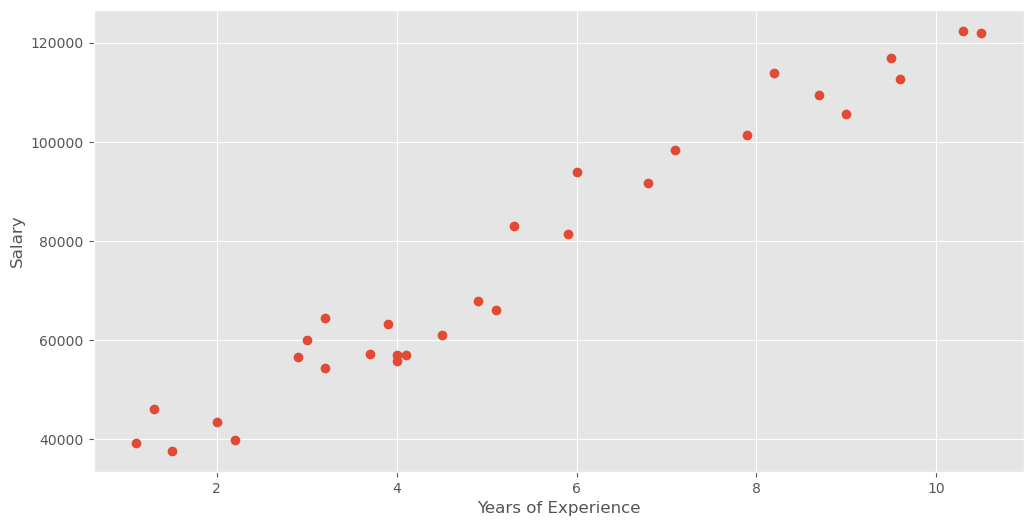

In [6]:
plt.plot(data["YearsExperience"], data["Salary"], "o")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
None

## Linear regression - General concept
A linear model assumes that the relationship between the dependent variable y and the our features x is linear and thus takes the form:

$y_i = \beta_{0} + \beta_{1} x_{i1} + \cdots + \beta_{p} x_{ip} + \varepsilon_i,
 \qquad i = 1, \ldots, n$


### Matrix notation

We can simplify the notation by adding a first column with a constant to $X$.

In particular,  ${\displaystyle \mathbf {x} _{i0}=1}$ for ${\displaystyle i=1,\ldots ,n}$. The corresponding element $\beta_0$ is called the intercept.

Then the previous formula can be written more compact in matrix notation as:
 
$\mathbf{y} = X\boldsymbol\beta + \boldsymbol\varepsilon$

where

${\displaystyle \mathbf {y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}},\quad }
{\displaystyle X={\begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix}}={\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix}},}$


${\displaystyle {\boldsymbol {\beta }}={\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}},\quad}
{{\boldsymbol {\varepsilon }}={\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}}.}$

- $\mathbf {y}$
 is a vector of observed values 
${\displaystyle y_{i}\ (i=1,\ldots ,n)}$
 of the variable called the regressand, endogenous variable or dependent variable. In our case this is the salary.
 
- ${\boldsymbol\displaystyle X}$ is a matrix of row-vectors ${\displaystyle \mathbf {x} _{i}}$ called independent variable and contains the features of our data points. In our case this is the years of experience.

- $\boldsymbol\varepsilon$ is called error term, disturbance term, or sometimes noise. This variable captures all other factors which influence the dependent variable y other than the regressors x.

- $\boldsymbol\beta$ is a vector of the regression coefficients. 
 

 

 
 
 
 
 https://en.wikipedia.org/wiki/Linear_regression

## Extract dependent and independent variables
We create a numpy vector of our independent variable and a numpy array of our independent variable.

Add a column full of ones to $X$ so that $x_{i0}=1$  for $i=1,\ldots ,n$. The corresponding element $\beta_0$ is called the intercept or bias.

In [7]:
y = data.iloc[:, 1].values.reshape(-1, 1)  # reshape to make sure y is a column vector

X = data.iloc[:, :-1].values
X_b = np.hstack((np.ones((X.shape[0], 1)), X))  # add x0 = 1 to each instance
X_b[:10, :]

array([[1. , 1.1],
       [1. , 1.3],
       [1. , 1.5],
       [1. , 2. ],
       [1. , 2.2],
       [1. , 2.9],
       [1. , 3. ],
       [1. , 3.2],
       [1. , 3.2],
       [1. , 3.7]])

What you mainly need is the formula for calculating the cost function $J(\boldsymbol\theta)$ and its derivative:

$J(\boldsymbol\beta) = \frac{1}{n} (\hat  {\mathbf y} − \mathbf{y})^T (\hat  {\mathbf y} − \mathbf{y}) 
= \frac{1}{n} (X\boldsymbol \beta − \mathbf{y})^T (X\boldsymbol \beta − \mathbf{y})$

$\nabla_\beta J(\boldsymbol\beta) = \frac{2}{n} X^T (X\boldsymbol \beta − \mathbf{y}) = \frac{2}{n} X^T ( \hat  {\mathbf y} − \mathbf{y})$

For a detailed derivation of the gradient in matrix notation check this lecture notes from Stanford:

http://cs229.stanford.edu/notes/cs229-notes1.pdf (chapter 2.2, page 11, they use theta instead of beta)


In [8]:
def predict(X_b: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    :param X_b: feature matrix including column of ones for bias
    :return: result of the linear regression
    """
    return np.dot(X_b, beta)


#  we actually don't need the cost function itself for gradient descent
#  but it is nice to have and certainly a good exercise for you ;)
def calc_cost(X_b: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: labels
    :param beta: regression coefficients
    :return: return cost
    """
    n = len(y)
    y_hat = predict(X_b, beta)
    return 1 / (2 * n) * np.sum(np.square((y - y_hat)))


# what we need is the gradient, which consists of the partial derivatives of the cost function
def calc_gradient(
    X_b: np.ndarray,
    y: np.ndarray,
    beta: np.ndarray,
    alpha: float = None,
    penalty_func=None,
) -> np.ndarray:
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: labels
    :param beta: regression coefficients
    :param alpha: for Lasso regression (you might need it for exercise 2 - bonus)
    :param penalty_func: the penalty function to be applied on the vector of coefficients, betas
    :return: gradient
    """
    n = len(y)
    y_hat = predict(X_b, beta)
    if alpha and penalty_func:
        grad = 1 / n * np.dot(X_b.T, (y_hat - y)) + alpha * penalty_func(
            beta
        )  #  np.sum(np.abs(beta))
    else:
        grad = 1 / n * np.dot(X_b.T, (y_hat - y))
    return grad


def update_beta(beta: np.ndarray, gradient: np.ndarray, learning_rate: float = 0.1):
    """
    :param beta: regression coefficient vector
    :param gradient: gradient vector
    :param lr: learning rate for updating beta
    :return: updated beta vector
    """
    return beta - learning_rate * gradient


def calc_rmse(y: np.ndarray, y_hat: np.ndarray):
    """
    :param y: vector of observed values
    :param y_hat: vector of estimated (predicted) values
    :return: root mean squared error (RMSE)
    """
    return np.sqrt(np.sum(np.square(y_hat - y)) / len(y))

Let's play a bit with beta to see what effect it has on our linear model:

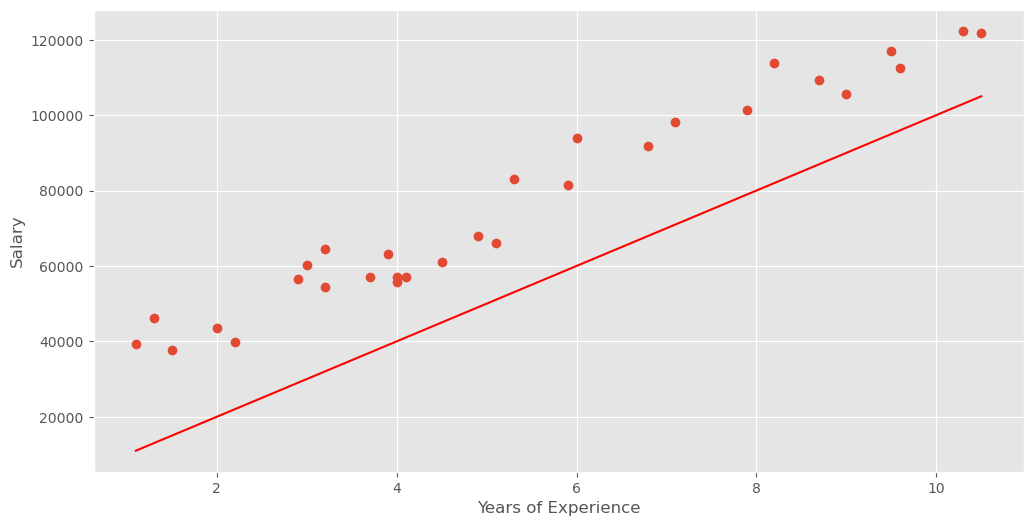

In [9]:
#  try different values and please keep in mind, that for the further calculations beta should be a column vector
beta = np.array([[0], [10000]])

plt.plot(X_b[:, 1], y, "o")
plt.plot(X_b[:, 1], predict(X_b, beta), c="red")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
None

# Gradient Decent

Initialise the regrission coefficient with random values.

In [10]:
def run_gradient_descent(
    gradient_descent_func: Callable,
    X_b: np.ndarray,
    y: np.ndarray,
    learning_rate: np.ndarray = 0.01,
    epochs: float = 100,
    beta: np.ndarray = None,
    verbose: bool = True,
    create_plot: bool = True,
    step_width_output: int = 100,
    **kwargs,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param epochs: number of iterations
    :param beta: regression coefficients
    :param verbose: print intermediate results
    :**kwargs: additional arguments for the gradient descent function
    :return:
        - beta_all - numpy array containing regression coefficients of all gradient descent steps
        - rmse_all - numpy array containing RMSE values of all gradient descent steps
    """
    # set missing parameters to default values
    if not beta:
        # Creates random start values for beta
        beta = np.random.rand(X_b.shape[1], 1)

    assert X_b.shape[1] == len(beta), "Check the shape of variables beta and X_b"
    assert X_b.shape[0] == y.shape[0], "Check the shape of variables X_b and y"

    # initialze arrays for storing intermediate results
    # for large arrays this is computational way more efficient than appending
    rmse_all = np.zeros(epochs + 1)  # vector for saving RMSE values
    rmse_all[0] = calc_rmse(y, predict(X_b, beta))  # insert current value
    beta_all = np.zeros((epochs + 1, len(beta)))  # array for storing beta vectors
    beta_all[0, :] = beta.T  #  insert current values

    if verbose:
        print("Epoch: {:4d}, RMSE: {:8.3f}, beta: {}".format(0, rmse_all[0], beta.T))
    if create_plot:
        fig, axs = plt.subplots(1, 3, figsize=(32, 6))
        axs[0].plot(X_b[:, 1], y, "b.")
    else:
        axs = None

    # main loop for iterative gradient descent
    for epoch in range(epochs):
        # call gradient descent function
        beta, y_hat, rmse = gradient_descent_func(X_b, y, beta, learning_rate, **kwargs)

        # add new values to arrays
        beta_all[epoch + 1, :] = beta.T  # Add new beta vector to array
        rmse_all[epoch + 1] = rmse  # Add new RMSE to vector

        if verbose and (epoch + 1) % step_width_output == 0:
            print(
                "Epoch: {:4d}, RMSE: {:8.3f}, beta: {}".format(epoch + 1, rmse, beta.T)
            )
        if create_plot and (epoch + 1) % step_width_output == 0:
            axs[0].plot(X_b[:, 1], y_hat, "r-", alpha=epoch / epochs)

    if verbose:
        print("")
    if create_plot:
        axs[0].set_xlabel("First Feature")
        axs[0].set_ylabel("Independent Variable")
        axs[1].plot(rmse_all, label="training loss")
        axs[1].legend(loc="best")
        axs[1].set_ylabel("RMSE")
        axs[1].set_xlabel("Epoch")
        axs[1].grid()
        axs[2].scatter(beta_all[:, 0], beta_all[:, 1], c=range(beta_all.shape[0]))
        axs[2].set_xlabel(r"$\beta_0$")
        axs[2].set_ylabel(r"$\beta_1$")

    return beta_all, rmse_all, axs

In [11]:
def gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    beta: np.ndarray = None,
    learning_rate: np.ndarray = 0.01,
):
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param beta: regression coefficients
    :return:
        - beta - updated regression coefficients
        - y_hat - estimated y
        - rmse - Root mean squared errors
    """
    grad = calc_gradient(X_b, y, beta)
    beta = update_beta(beta, grad, learning_rate)
    y_hat = predict(X_b, beta)
    rmse = calc_rmse(y, y_hat)

    return beta, y_hat, rmse

Epoch:    0, RMSE: 80638.347, beta: [[0.67223665 0.32475271]]
Epoch:  100, RMSE: 10577.246, beta: [[ 6482.41157606 12315.45411111]]
Epoch:  200, RMSE: 9167.816, beta: [[10167.31974311 11768.62916628]]
Epoch:  300, RMSE: 8113.416, beta: [[13149.03283822 11326.15542614]]
Epoch:  400, RMSE: 7341.458, beta: [[15561.74234916 10968.11943571]]
Epoch:  500, RMSE: 6788.627, beta: [[17514.03185471 10678.4078465 ]]
Epoch:  600, RMSE: 6400.845, beta: [[19093.76381009 10443.98223799]]
Epoch:  700, RMSE: 6133.676, beta: [[20372.03378172 10254.29232578]]
Epoch:  800, RMSE: 5952.253, beta: [[21406.37009098 10100.80114782]]
Epoch:  900, RMSE: 5830.408, beta: [[22243.32286654  9976.60085989]]
Epoch: 1000, RMSE: 5749.231, beta: [[22920.55902487  9876.1018493 ]]
Epoch: 1100, RMSE: 5695.453, beta: [[23468.55746344  9794.78117525]]
Epoch: 1200, RMSE: 5659.965, beta: [[23911.98075821  9728.97901473]]
Epoch: 1300, RMSE: 5636.608, beta: [[24270.78509871  9675.73395277]]
Epoch: 1400, RMSE: 5621.262, beta: [[245

(4000.0, 10000.0)

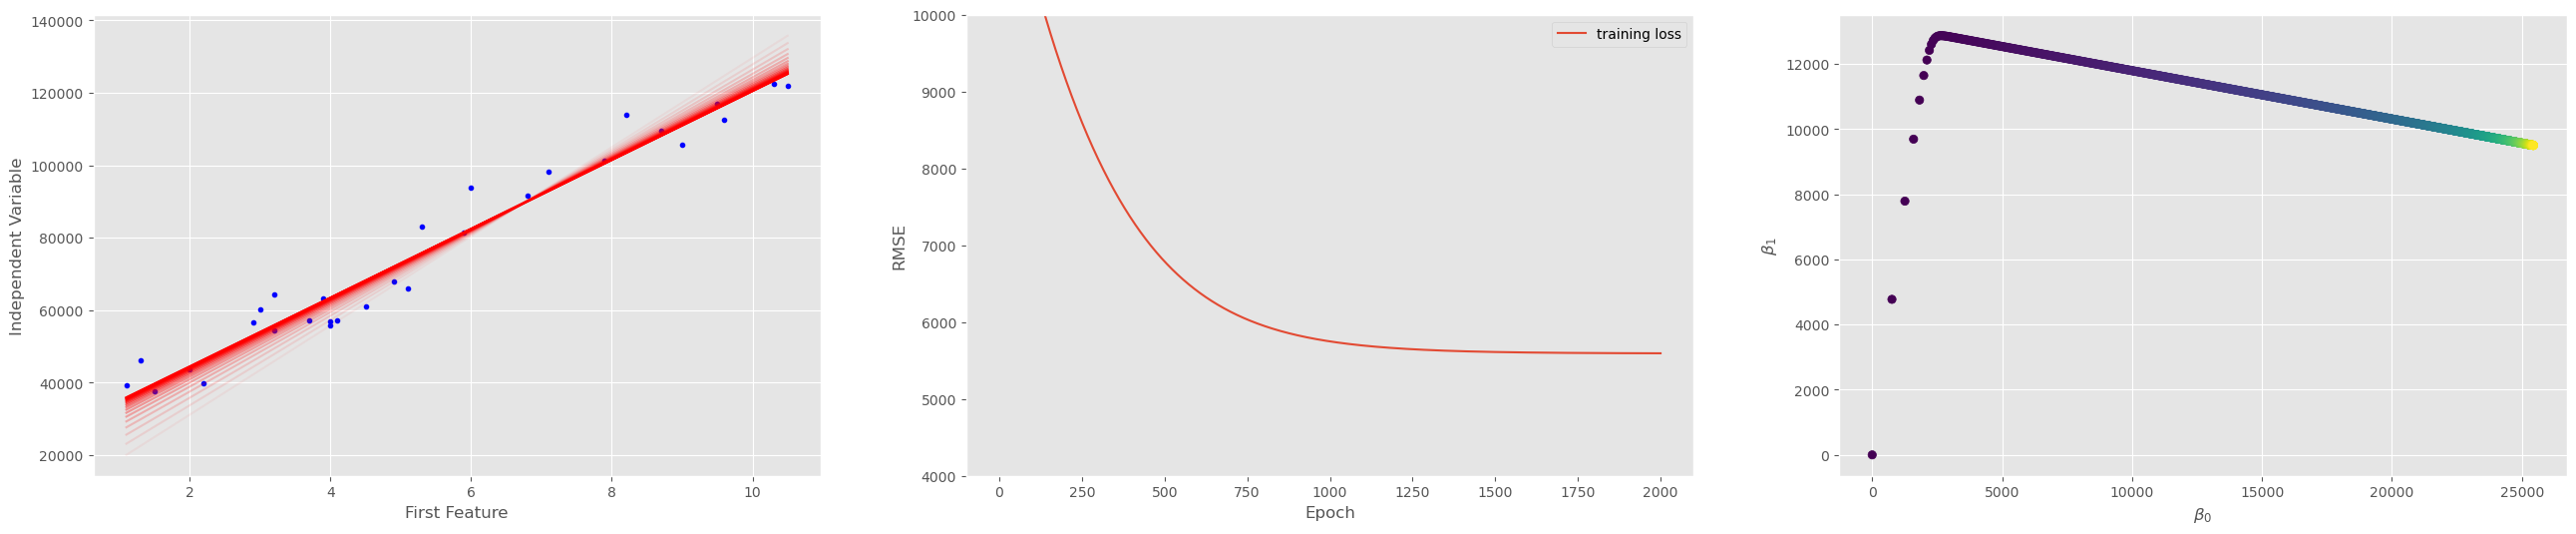

In [12]:
learning_rate = 0.01
epochs = 2000

beta_all, rmse_all, axs = run_gradient_descent(
    gradient_descent, X_b, y, learning_rate, epochs, verbose=True
)
axs[1].set_ylim((4000, 10000))

In [13]:
# we will store it to compare with sklearn model later
rmse_all_gd = rmse_all

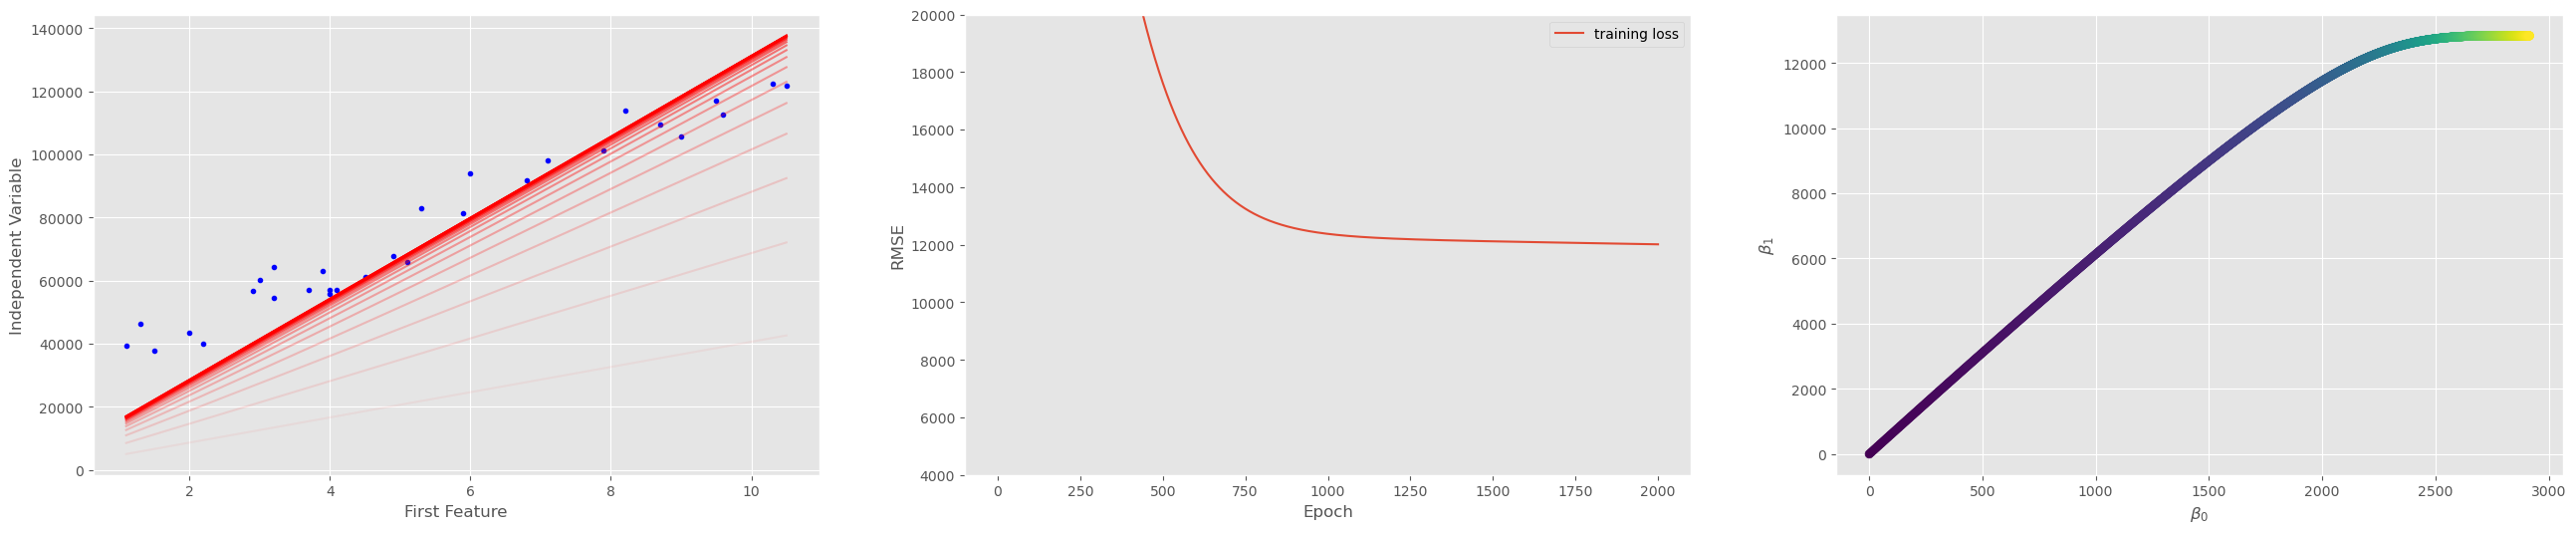

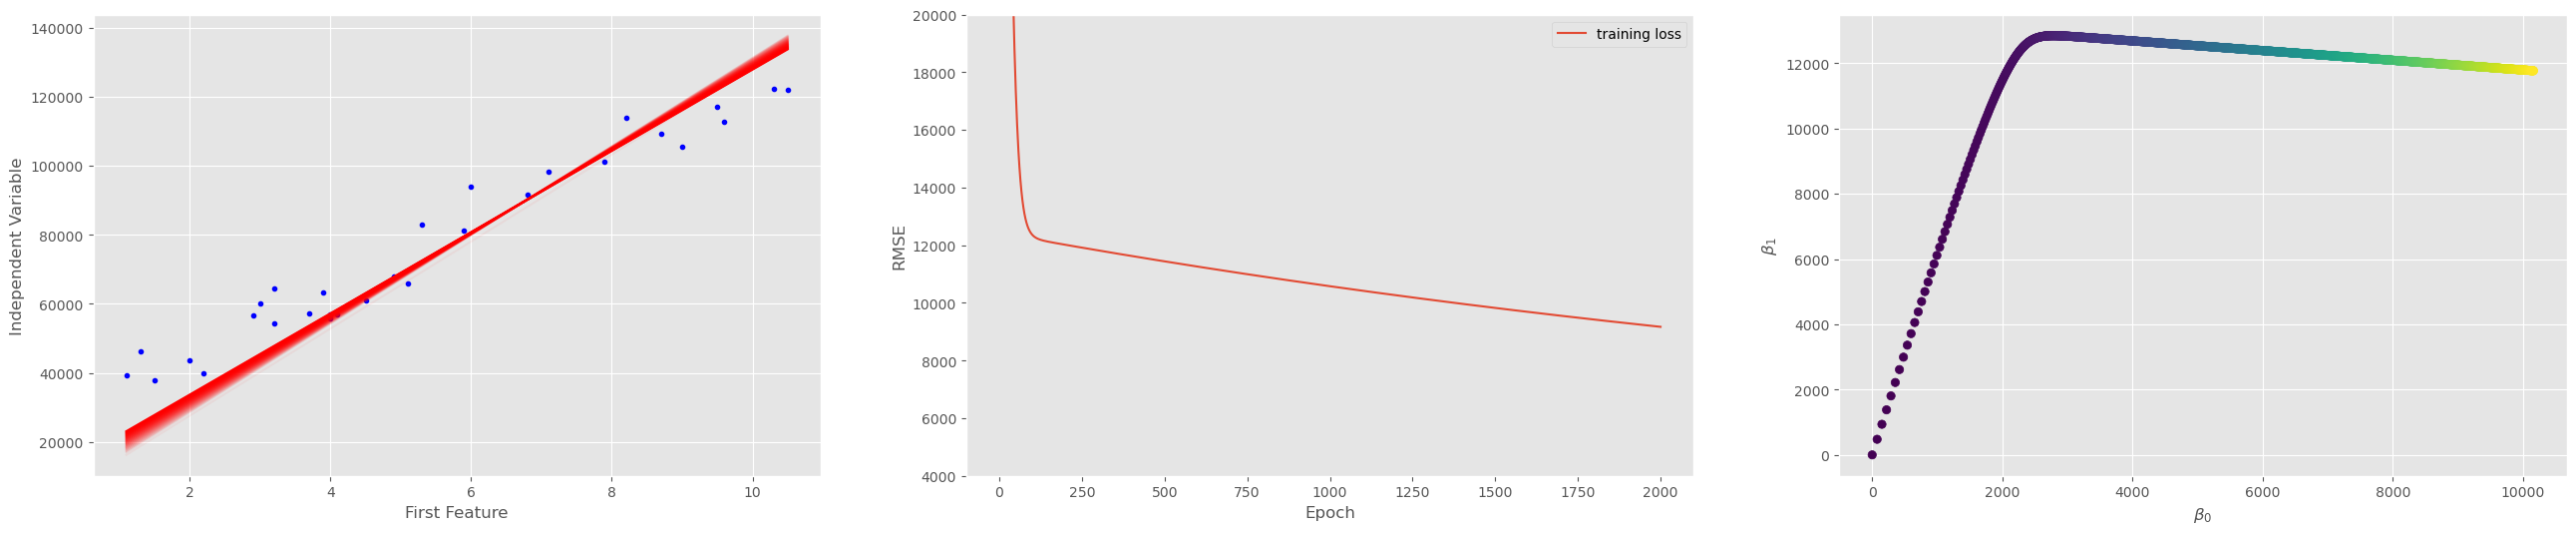

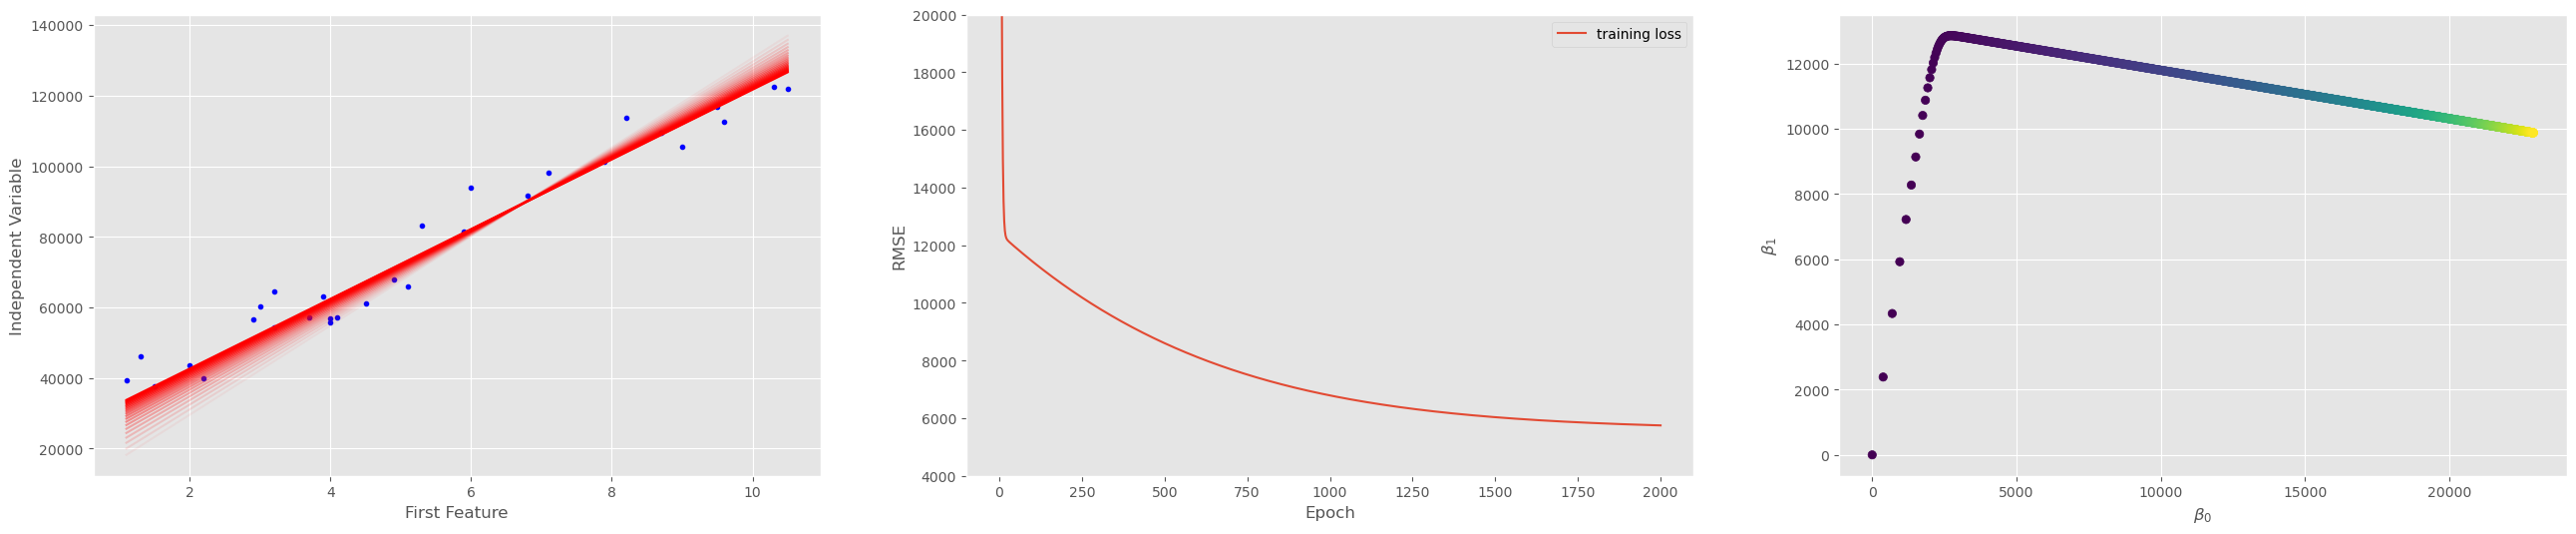

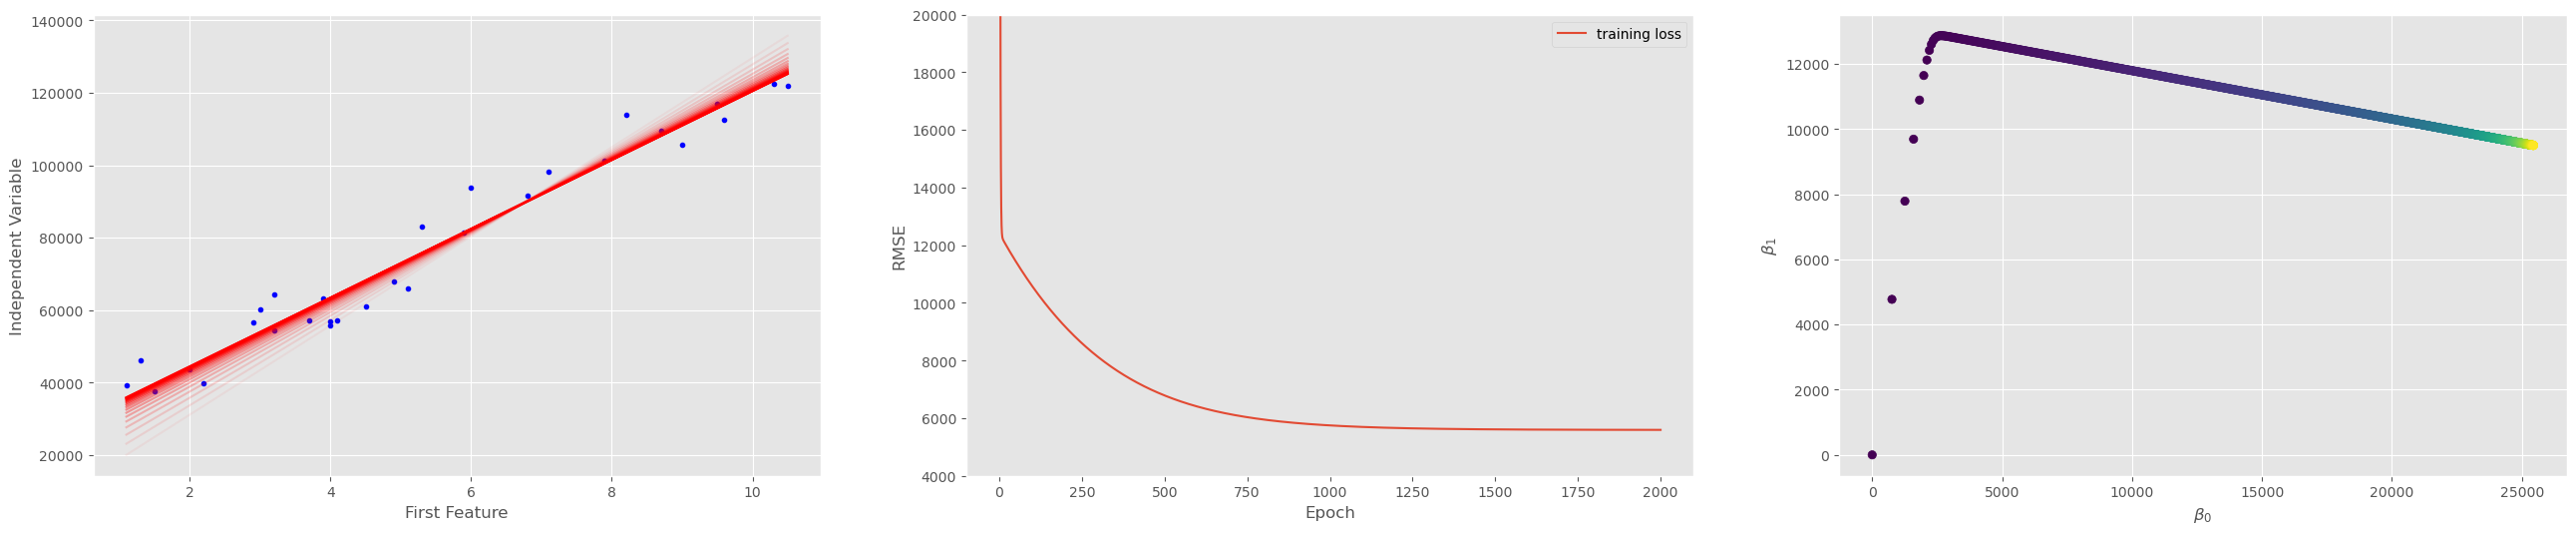

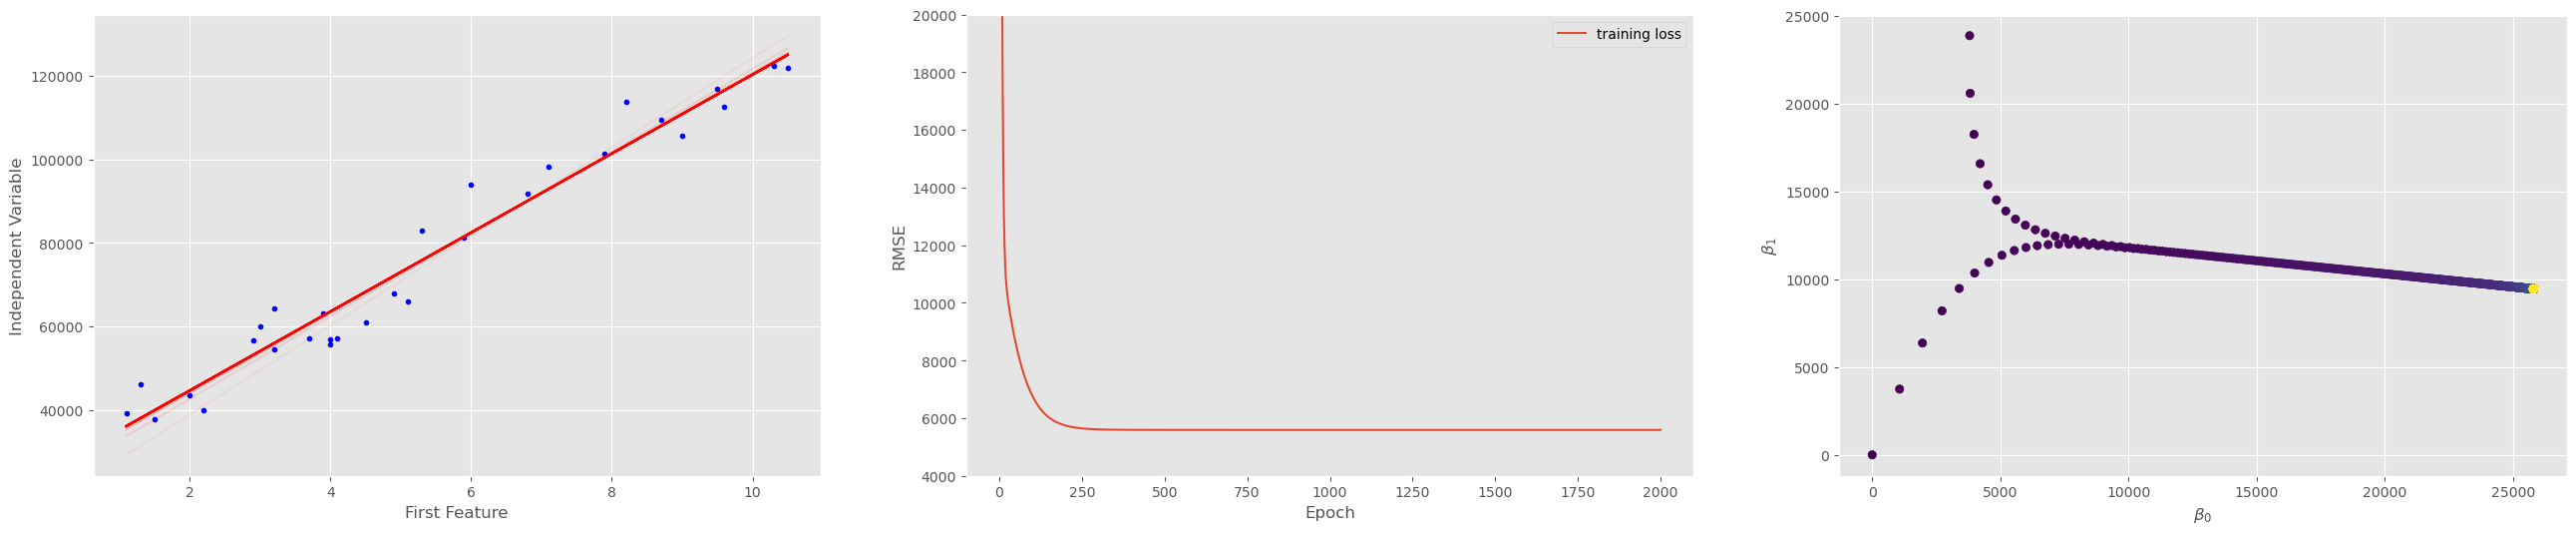

In [14]:
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05]
epochs = 2000

for ind in range(len(learning_rates)):
    learning_rate = learning_rates[ind]
    beta_all, rmse_all, axs = run_gradient_descent(
        gradient_descent, X_b, y, learning_rate, epochs, verbose=False
    )
    axs[1].set_ylim((4000, 20000))

# Stochastic Gradient Descent

In [15]:
# shuffling points before each iteration, then selecting first N points
# This obtains a less biased estimation of the true gradient.
# https://www.quora.com/Why-do-we-need-to-shuffle-inputs-for-stochastic-gradient-descent

In [16]:
def stochastic_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    beta: np.ndarray = None,
    learning_rate: np.ndarray = 0.01,
    shuffle_values: bool = True,
):
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param beta: regression coefficients
    :param shuffle_values: shuffle X_b and y
    :return:
        - beta - updated regression coefficients
        - y_hat - estimated y
        - rmse - Root mean squared errors
    """
    # gradient descent
    if shuffle_values:
        X_shuffled, y_shuffled = shuffle(X_b, y)
    else:
        X_shuffled, y_shuffled = X_b, y

    for ind_point in range(X_b.shape[0]):
        X_selected = X_shuffled[ind_point, :].reshape(1, -1)
        y_selected = y_shuffled[ind_point].reshape(1, -1)

        grad = calc_gradient(X_selected, y_selected, beta)
        if inspect.isgenerator(learning_rate):
            beta = update_beta(beta, grad, next(learning_rate))
        else:
            beta = update_beta(beta, grad, learning_rate)
    y_hat = predict(X_b, beta)
    rmse = calc_rmse(y, y_hat)
    return beta, y_hat, rmse

Epoch:    0, RMSE: 80637.422, beta: [[0.39442171 0.52522222]]
Epoch:  100, RMSE: 5612.140, beta: [[25672.57514123  9546.13199066]]
Epoch:  200, RMSE: 6102.209, beta: [[25590.1675053   9073.07208575]]
Epoch:  300, RMSE: 6718.853, beta: [[25459.59531047  8878.95540118]]
Epoch:  400, RMSE: 5800.067, beta: [[26047.02602073  9668.11999024]]
Epoch:  500, RMSE: 8029.028, beta: [[25994.68151639 10379.98329377]]
Epoch:  600, RMSE: 5776.933, beta: [[25957.05944743  9666.88601981]]
Epoch:  700, RMSE: 6085.841, beta: [[26132.81843733  9000.45057792]]
Epoch:  800, RMSE: 7201.697, beta: [[25890.09815547 10191.64113186]]
Epoch:  900, RMSE: 7483.753, beta: [[26068.02600189 10237.71916946]]
Epoch: 1000, RMSE: 6084.264, beta: [[25770.27701399  9053.73306922]]
Epoch: 1100, RMSE: 6099.066, beta: [[25942.67454998  9833.2817958 ]]
Epoch: 1200, RMSE: 5609.343, beta: [[25974.41963485  9351.10135979]]
Epoch: 1300, RMSE: 6459.356, beta: [[25894.82804519  9973.47335845]]
Epoch: 1400, RMSE: 5811.415, beta: [[2586

(4000.0, 10000.0)

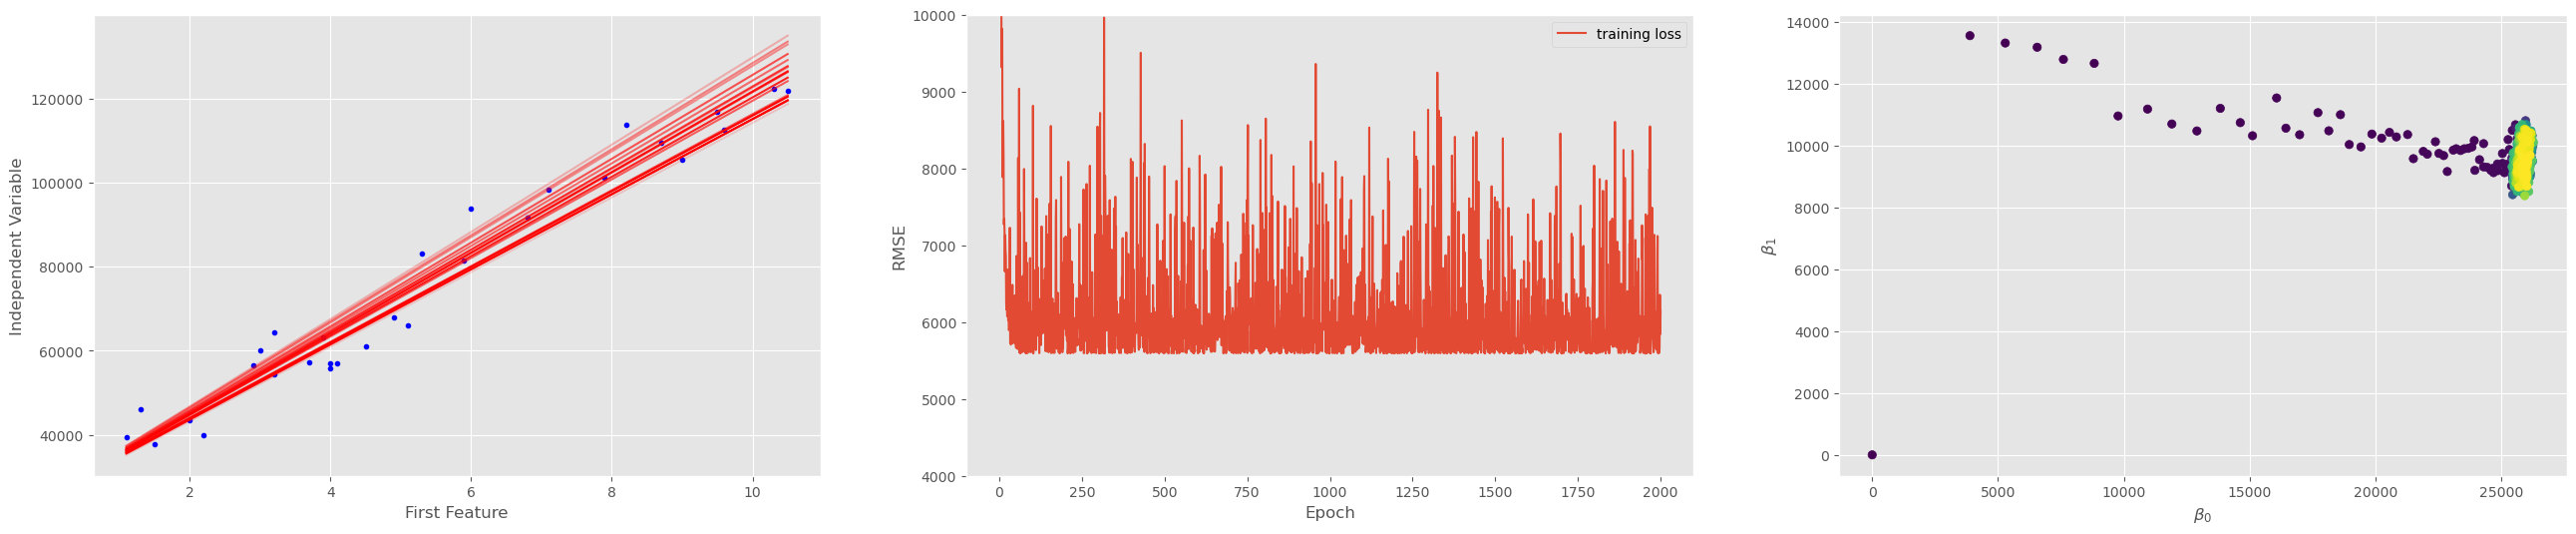

In [17]:
learning_rate = 0.01
epochs = 2000
beta_all, rmse_all, axs = run_gradient_descent(
    stochastic_gradient_descent, X_b, y, learning_rate, epochs, verbose=True
)
axs[1].set_ylim((4000, 10000))

You can see that the parameters are aproaching much faster the vicinity of the solution when we use stochastic gradient descent. However, it introduces a lot of noise which prevents it from converging to the exact solution. 

## Stochastic Gradient Descent + Learning Rate Scheduler

In [18]:
def learning_rate_scheduler(t0=3, t1=50):
    t = 0
    while True:
        yield t0 / (t + t1)
        t += 1

Epoch:    0, RMSE: 80635.603, beta: [[0.60646637 0.79868565]]
Epoch:  100, RMSE: 5690.174, beta: [[23547.91910214  9803.65092246]]
Epoch:  200, RMSE: 5633.674, beta: [[24337.60607392  9647.89790555]]
Epoch:  300, RMSE: 5616.475, beta: [[24669.4464386   9609.44410019]]
Epoch:  400, RMSE: 5608.901, beta: [[24857.84495534  9586.04319889]]
Epoch:  500, RMSE: 5604.745, beta: [[24981.73520284  9572.04751832]]
Epoch:  600, RMSE: 5602.158, beta: [[25069.73730246  9553.23166801]]
Epoch:  700, RMSE: 5600.329, beta: [[25137.71264384  9548.48281826]]
Epoch:  800, RMSE: 5599.057, beta: [[25190.34019284  9536.43594974]]
Epoch:  900, RMSE: 5598.061, beta: [[25234.10314767  9532.70658901]]
Epoch: 1000, RMSE: 5597.309, beta: [[25270.1302283   9527.28389617]]
Epoch: 1100, RMSE: 5596.719, beta: [[25300.576792    9521.12726313]]
Epoch: 1200, RMSE: 5596.229, beta: [[25327.53252729  9520.56737848]]
Epoch: 1300, RMSE: 5595.818, beta: [[25350.42628513  9516.23363744]]
Epoch: 1400, RMSE: 5595.479, beta: [[2537

(4000.0, 10000.0)

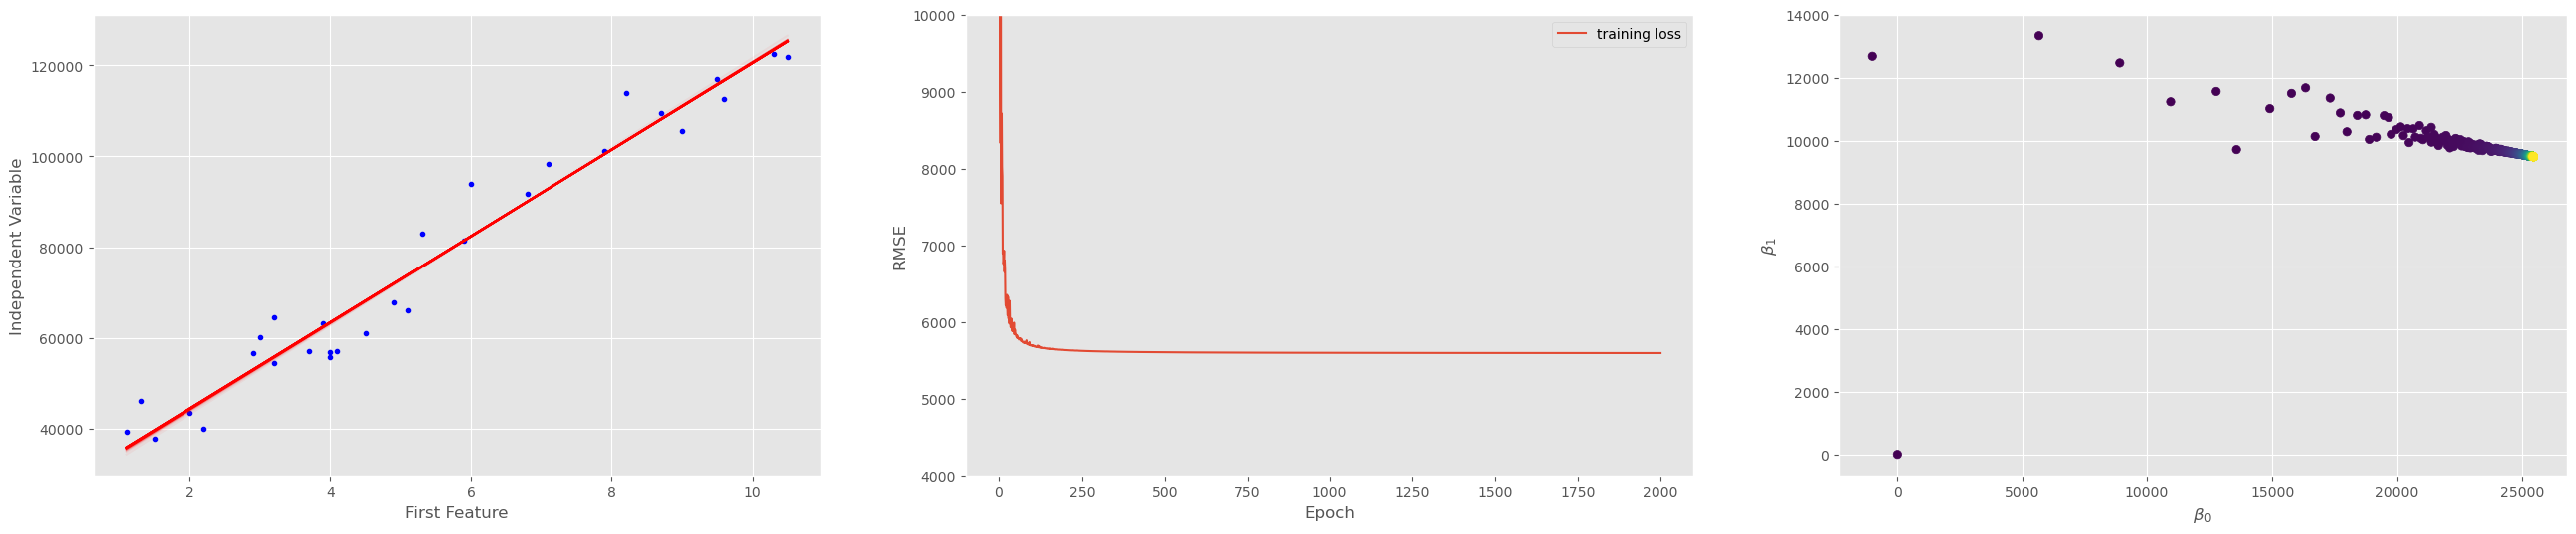

In [19]:
learning_rate = learning_rate_scheduler()
epochs = 2000
beta_all, rmse_all, axs = run_gradient_descent(
    stochastic_gradient_descent, X_b, y, learning_rate, epochs, verbose=True
)
axs[1].set_ylim((4000, 10000))

# BONUS: Mini Batch

In [20]:
def mini_batch_gradient_descent(
    X_b,
    y,
    beta,
    learning_rate,
    shuffle_values=True,
    batch_size=None,
    alpha=None,
    penalty_func=None,
):
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param beta: regression coefficients
    :param shuffle_values: shuffle X_b and y
    :param batch_size: number of elements per batch
    :return:
        - beta - updated regression coefficients
        - y_hat - estimated y
        - rmse - Root mean squared errors
    """

    # if required shuffle X_b and y
    if shuffle_values:
        X_shuffled, y_shuffled = shuffle(X_b, y)
    else:
        X_shuffled, y_shuffled = X_b, y
    if not batch_size:
        batch_size = X_b.shape[0]

    # loop in mini batches over the whole dataset
    for ind_batch in range(0, X_b.shape[0], batch_size):
        # take care of the case X_b.shape[0]%batch_size != 0
        ind_batch_end = min(ind_batch + batch_size, X_b.shape[0])

        # select mini batch
        X_selected = X_shuffled[ind_batch:ind_batch_end, :]
        y_selected = y_shuffled[ind_batch:ind_batch_end]

        # gradient descent
        grad = calc_gradient(X_selected, y_selected, beta, alpha, penalty_func)
        if inspect.isgenerator(learning_rate):
            beta = update_beta(beta, grad, next(learning_rate))
        else:
            beta = update_beta(beta, grad, learning_rate)

    # prediction on the full data set
    y_hat = predict(X_b, beta)
    rmse = calc_rmse(y, y_hat)  # of the full data set
    return beta, y_hat, rmse

Epoch:    0, RMSE: 80639.010, beta: [[0.78353843 0.19497517]]
Epoch:  100, RMSE: 8106.522, beta: [[13198.66202516 11375.14924438]]
Epoch:  200, RMSE: 6387.192, beta: [[19153.91342251 10430.17416279]]
Epoch:  300, RMSE: 5836.653, beta: [[22302.72043788 10032.13641597]]
Epoch:  400, RMSE: 5657.506, beta: [[23946.40954743  9722.41206268]]
Epoch:  500, RMSE: 5616.946, beta: [[24827.13060498  9638.81472371]]
Epoch:  600, RMSE: 5609.792, beta: [[25289.38446454  9587.40766919]]
Epoch:  700, RMSE: 5593.388, beta: [[25531.36247235  9485.41510075]]
Epoch:  800, RMSE: 5592.457, beta: [[25645.92809787  9471.20686603]]
Epoch:  900, RMSE: 5592.861, beta: [[25717.62800259  9475.81382956]]
Epoch: 1000, RMSE: 5592.940, beta: [[25752.9545698   9439.34646398]]
Epoch: 1100, RMSE: 5619.189, beta: [[25786.07145346  9542.78816036]]
Epoch: 1200, RMSE: 5594.562, beta: [[25782.52488652  9423.43150114]]
Epoch: 1300, RMSE: 5593.052, beta: [[25788.43399994  9432.82126574]]
Epoch: 1400, RMSE: 5593.540, beta: [[2579

(4000.0, 10000.0)

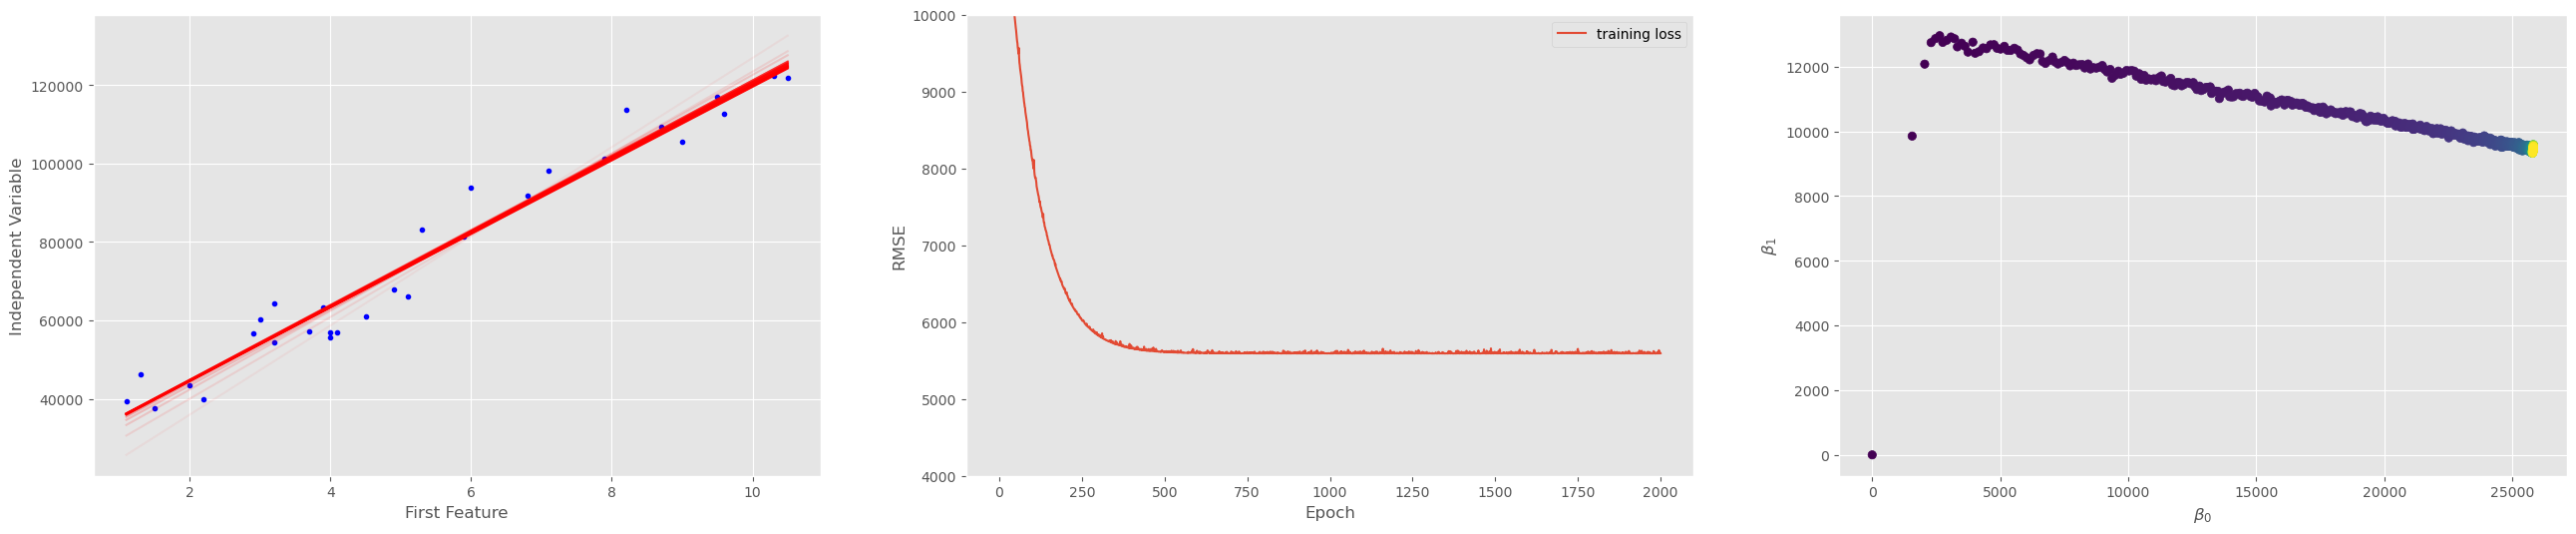

In [21]:
learning_rate = 0.01
epochs = 2000

beta_all, rmse_all, axs = run_gradient_descent(
    mini_batch_gradient_descent,
    X_b,
    y,
    learning_rate,
    epochs,
    batch_size=10,
    shuffle_values=True,
    verbose=True,
    create_plot=True,
)

axs[1].set_ylim((4000, 10000))

## BONUS: Mini-Batch Gradient Descent + Learning Rate Scheduler

In [22]:
def learning_rate_scheduler(t0=5, t1=100):
    t = 0
    while True:
        yield t0 / (t + t1)
        t += 1

Epoch:    0, RMSE: 80639.975, beta: [[0.48890085 0.07895868]]
Epoch:  100, RMSE: 6180.957, beta: [[20440.29449654 10095.96629855]]
Epoch:  200, RMSE: 5755.493, beta: [[22865.27825568  9872.65517019]]
Epoch:  300, RMSE: 5669.686, beta: [[23788.39019707  9732.16234115]]
Epoch:  400, RMSE: 5636.451, beta: [[24278.15268668  9682.64777328]]
Epoch:  500, RMSE: 5620.541, beta: [[24577.3679028   9632.98106194]]
Epoch:  600, RMSE: 5611.871, beta: [[24778.81164237  9597.3455203 ]]
Epoch:  700, RMSE: 5606.537, beta: [[24925.69658701  9578.40146156]]
Epoch:  800, RMSE: 5603.118, beta: [[25035.97047538  9564.69945082]]
Epoch:  900, RMSE: 5600.753, beta: [[25120.83219953  9547.83503074]]
Epoch: 1000, RMSE: 5599.047, beta: [[25190.05364893  9538.63288353]]
Epoch: 1100, RMSE: 5597.796, beta: [[25246.51032882  9530.60707105]]
Epoch: 1200, RMSE: 5596.890, beta: [[25292.86576677  9520.57296092]]
Epoch: 1300, RMSE: 5596.117, beta: [[25333.15459087  9518.53888969]]
Epoch: 1400, RMSE: 5595.544, beta: [[2536

(4000.0, 10000.0)

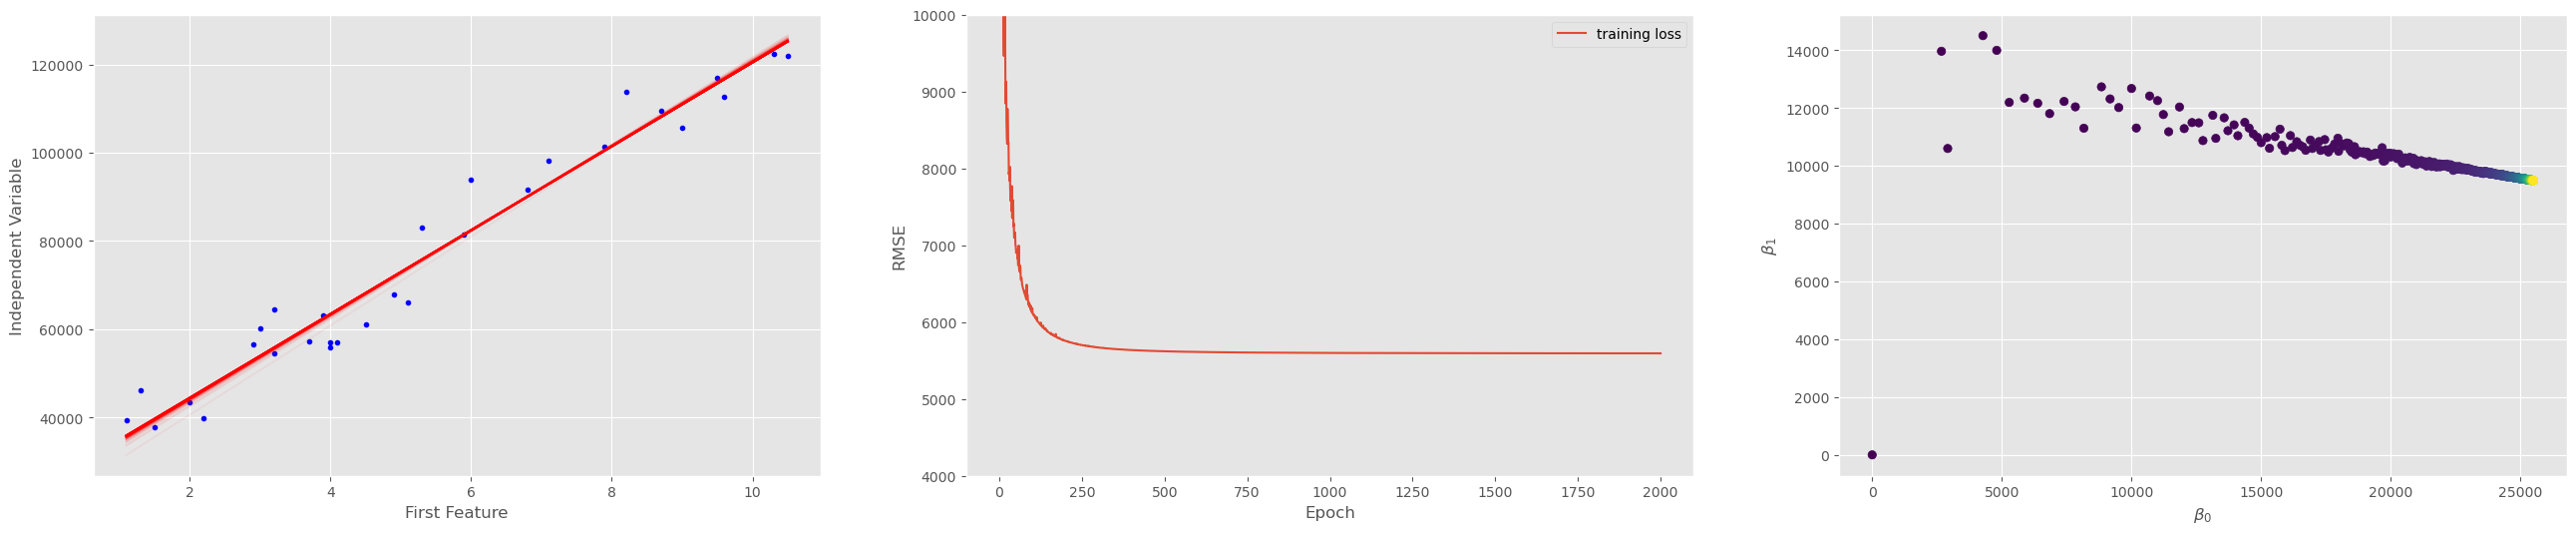

In [23]:
learning_rate = learning_rate_scheduler(5, 100)
epochs = 2000

beta_all, rmse_all, axs = run_gradient_descent(
    mini_batch_gradient_descent,
    X_b,
    y,
    learning_rate,
    epochs,
    batch_size=10,
    shuffle_values=True,
    verbose=True,
    create_plot=True,
)

axs[1].set_ylim((4000, 10000))

# Sklearn

Compare your results with the solver from sklearn.

In [24]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X, y)

LinearRegression()

In [25]:
# Make predictions
y_hat = regr.predict(X)

# Print the coefficients
print("Coefficients: ", [regr.intercept_[0], regr.coef_[0, 0]])

# The root mean squared error
RMSE_sklearn = np.sqrt(mean_squared_error(y, y_hat))
print(f"RMSE: {RMSE_sklearn:.2f}")

Coefficients:  [25792.200198668696, 9449.962321455076]
RMSE: 5592.04


In [26]:
# how different Gradient Decent RMSE on the last iteration and RMSE from sklearn regression
(rmse_all_gd[-1] - RMSE_sklearn) / RMSE_sklearn

0.0004126692012382856

We can see that RMSE from our regression with Gradient Descent is only slightly (by ~ 0.05 %) different from that of sklearn model. 

--------------
# End of This Notebook